Credit: https://www.kaggle.com/chryzal/un-dernier-pour-la-route

#### This is how I've done went I want to get a high LB rank without doing any effort to solve the problem 

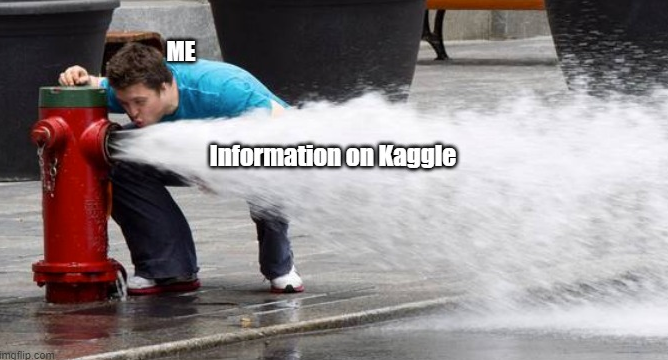

credit @thomasdubail : [notebook](https://www.kaggle.com/thomasdubail/jigsaw-ensemble-best-public-sub-0-898)

In [ ]:
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sb

[Sub1 : 0.869](https://www.kaggle.com/ayhampar/very-simple-code-with-score-0-869/notebook)

Credit : [very simple code with score 0.886](https://www.kaggle.com/ayhampar/very-simple-code-with-score-0-886?scriptVersionId=85850016) by [AYAHM BARISH](https://www.kaggle.com/ayhampar)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.stats import rankdata

jr = pd.read_csv("../input/jigsaw-regression-based-data/train_data_version2.csv")
jr.shape
df = jr[['text', 'y']]
vec = TfidfVectorizer(analyzer='char_wb', max_df=0.8, min_df=1, ngram_range=(2, 5) )
X = vec.fit_transform(df['text'])
z = df["y"].values
y=np.around ( z ,decimals = 2)

model1=Ridge(alpha=0.5)
model1.fit(X, y)
df_test = pd.read_csv("../input/jigsaw-toxic-severity-rating/comments_to_score.csv")
test=vec.transform(df_test['text'])
jr_preds=model1.predict(test)
df_test['score1']=rankdata( jr_preds, method='ordinal') 
rud_df = pd.read_csv("../input/ruddit-jigsaw-dataset/Dataset/ruddit_with_text.csv")
#print(f"rud_df:{rud_df.shape}")
rud_df['y'] = rud_df["offensiveness_score"] 
df = rud_df[['txt', 'y']].rename(columns={'txt': 'text'})
vec = TfidfVectorizer(analyzer='char_wb', max_df=0.8, min_df=3, ngram_range=(3, 4) )
X = vec.fit_transform(df['text'])
z = df["y"].values
y=np.around ( z ,decimals = 1)
model1=Ridge(alpha=0.5)
model1.fit(X, y)
test=vec.transform(df_test['text'])
rud_preds=model1.predict(test)
df_test['score2']=rankdata( rud_preds, method='ordinal')
df_test['score']=df_test['score1']+df_test['score2']
df_test['score']=rankdata( df_test['score'], method='ordinal')
df_test[['comment_id', 'score']].to_csv("submission1.csv", index=False)

[Sub2 : 0.860](https://www.kaggle.com/coldfir3/tokenizer-training-tfidf-ridge-lb-0-860)

Credit : [Tokenizer training + TFIDF + RIDGE [LB 0.860]](https://www.kaggle.com/coldfir3/tokenizer-training-tfidf-ridge-lb-0-860) by [Adriano Passos](https://www.kaggle.com/coldfir3)

In [ ]:
import numpy as np
import pandas as pd
import nltk
import re
from bs4 import BeautifulSoup
from tqdm.auto import tqdm

TRAIN_DATA_PATH = "/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv"
VALID_DATA_PATH = "/kaggle/input/jigsaw-toxic-severity-rating/validation_data.csv"
TEST_DATA_PATH = "/kaggle/input/jigsaw-toxic-severity-rating/comments_to_score.csv"

df_train2 = pd.read_csv(TRAIN_DATA_PATH)
df_valid2 = pd.read_csv(VALID_DATA_PATH)
df_test2 = pd.read_csv(TEST_DATA_PATH)
cat_mtpl = {'obscene': 0.16, 'toxic': 0.32, 'threat': 1.5, 
            'insult': 0.64, 'severe_toxic': 1.5, 'identity_hate': 1.5}

for category in cat_mtpl:
    df_train2[category] = df_train2[category] * cat_mtpl[category]

df_train2['score'] = df_train2.loc[:, 'toxic':'identity_hate'].mean(axis=1)

df_train2['y'] = df_train2['score']

min_len = (df_train2['y'] > 0).sum()  # len of toxic comments
df_y0_undersample = df_train2[df_train2['y'] == 0].sample(n=min_len, random_state=41)  # take non toxic comments
df_train_new = pd.concat([df_train2[df_train2['y'] > 0], df_y0_undersample])  # make new df
from tokenizers import (
    decoders,
    models,
    normalizers,
    pre_tokenizers,
    processors,
    trainers,
    Tokenizer,
)

raw_tokenizer = Tokenizer(models.WordPiece(unk_token="[UNK]"))
raw_tokenizer.normalizer = normalizers.BertNormalizer(lowercase=True)
raw_tokenizer.pre_tokenizer = pre_tokenizers.BertPreTokenizer()
special_tokens = ["[UNK]", "[PAD]", "[CLS]", "[SEP]", "[MASK]"]
trainer = trainers.WordPieceTrainer(vocab_size=25000, special_tokens=special_tokens)
from datasets import Dataset

dataset = Dataset.from_pandas(df_train_new[['comment_text']])

def get_training_corpus():
    for i in range(0, len(dataset), 1000):
        yield dataset[i : i + 1000]["comment_text"]

raw_tokenizer.train_from_iterator(get_training_corpus(), trainer=trainer)

from transformers import PreTrainedTokenizerFast

tokenizer = PreTrainedTokenizerFast(
    tokenizer_object=raw_tokenizer,
    unk_token="[UNK]",
    pad_token="[PAD]",
    cls_token="[CLS]",
    sep_token="[SEP]",
    mask_token="[MASK]",
)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Ridge

def dummy_fun(doc):
    return doc

labels = df_train_new['y']
comments = df_train_new['comment_text']
tokenized_comments = tokenizer(comments.to_list())['input_ids']

vectorizer = TfidfVectorizer(
    analyzer = 'word',
    tokenizer = dummy_fun,
    preprocessor = dummy_fun,
    token_pattern = None)

comments_tr = vectorizer.fit_transform(tokenized_comments)

regressor = Ridge(random_state=42, alpha=0.8)
regressor.fit(comments_tr, labels)

less_toxic_comments = df_valid2['less_toxic']
more_toxic_comments = df_valid2['more_toxic']

less_toxic_comments = tokenizer(less_toxic_comments.to_list())['input_ids']
more_toxic_comments = tokenizer(more_toxic_comments.to_list())['input_ids']

less_toxic = vectorizer.transform(less_toxic_comments)
more_toxic = vectorizer.transform(more_toxic_comments)

# make predictions
y_pred_less = regressor.predict(less_toxic)
y_pred_more = regressor.predict(more_toxic)

print(f'val : {(y_pred_less < y_pred_more).mean()}')
texts = df_test2['text']
texts = tokenizer(texts.to_list())['input_ids']
texts = vectorizer.transform(texts)

df_test2['prediction'] = regressor.predict(texts)
df_test2 = df_test2[['comment_id','prediction']]

df_test2['score'] = df_test2['prediction']
df_test2 = df_test2[['comment_id','score']]

df_test2.to_csv('./submission2.csv', index=False)

[Sub3 : 0.858](https://www.kaggle.com/tenffe/rapids-tfidf-linear-model-ensemble/notebook)

Credit : [[RAPIDS] TFIDF_linear_model_ensemble](https://www.kaggle.com/tenffe/rapids-tfidf-linear-model-ensemble/notebook) by [zhangxin](https://www.kaggle.com/tenffe)

In [ ]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
from bs4 import BeautifulSoup
from collections import defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

import re 
import scipy
from scipy import sparse

from IPython.display import display
from pprint import pprint
from matplotlib import pyplot as plt 

import time
import scipy.optimize as optimize
import warnings
warnings.filterwarnings("ignore")
pd.options.display.max_colwidth=300
pd.options.display.max_columns = 100

from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
from sklearn.linear_model import Ridge, Lasso, BayesianRidge
from sklearn.svm import SVR

df_train = pd.read_csv("../input/jigsaw-toxic-comment-classification-challenge/train.csv")
df_sub = pd.read_csv("../input/jigsaw-toxic-severity-rating/comments_to_score.csv")

cat_mtpl = {'obscene': 0.16, 'toxic': 0.32, 'threat': 1.5, 
            'insult': 0.64, 'severe_toxic': 1.5, 'identity_hate': 1.5}

for category in cat_mtpl:
    df_train[category] = df_train[category] * cat_mtpl[category]

df_train['score'] = df_train.loc[:, 'toxic':'identity_hate'].sum(axis=1)

df_train['y'] = df_train['score']

min_len = (df_train['y'] > 0).sum()  # len of toxic comments
df_y0_undersample = df_train[df_train['y'] == 0].sample(n=min_len, random_state=201)  # take non toxic comments
df_train_new = pd.concat([df_train[df_train['y'] > 0], df_y0_undersample])  # make new df
df_train = df_train.rename(columns={'comment_text':'text'})

def text_cleaning(text):
    '''
    Cleans text into a basic form for NLP. Operations include the following:-
    1. Remove special charecters like &, #, etc
    2. Removes extra spaces
    3. Removes embedded URL links
    4. Removes HTML tags
    5. Removes emojis
    
    text - Text piece to be cleaned.
    '''
    template = re.compile(r'https?://\S+|www\.\S+') #Removes website links
    text = template.sub(r'', text)
    
    soup = BeautifulSoup(text, 'lxml') #Removes HTML tags
    only_text = soup.get_text()
    text = only_text
    
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    
    text = re.sub(r"[^a-zA-Z\d]", " ", text) #Remove special Charecters
    text = re.sub(' +', ' ', text) #Remove Extra Spaces
    text = text.strip() # remove spaces at the beginning and at the end of string

    return text

tqdm.pandas()
df_train['text'] = df_train['text'].progress_apply(text_cleaning)
df = df_train.copy()
df['y'].value_counts(normalize=True)
min_len = (df['y'] >= 0.1).sum()
df_y0_undersample = df[df['y'] == 0].sample(n=min_len * 2, random_state=402)
df = pd.concat([df[df['y'] >= 0.1], df_y0_undersample])
vec = TfidfVectorizer(min_df= 3, max_df=0.8, analyzer = 'char_wb', ngram_range = (3,5))
X = vec.fit_transform(df['text'])
model = Ridge(alpha=0.5)
model.fit(X, df['y'])
l_model = Ridge(alpha=1.)
l_model.fit(X, df['y'])
s_model = Ridge(alpha=2.)
s_model.fit(X, df['y'])
df_val = pd.read_csv("../input/jigsaw-toxic-severity-rating/validation_data.csv")
tqdm.pandas()
df_val['less_toxic'] = df_val['less_toxic'].progress_apply(text_cleaning)
df_val['more_toxic'] = df_val['more_toxic'].progress_apply(text_cleaning)
X_less_toxic = vec.transform(df_val['less_toxic'])
X_more_toxic = vec.transform(df_val['more_toxic'])
p1 = model.predict(X_less_toxic)
p2 = model.predict(X_more_toxic)
# Validation Accuracy
print(f'val : {(p1 < p2).mean()}')
df_sub = pd.read_csv("../input/jigsaw-toxic-severity-rating/comments_to_score.csv")
tqdm.pandas()
df_sub['text'] = df_sub['text'].progress_apply(text_cleaning)
X_test = vec.transform(df_sub['text'])
p3 = model.predict(X_test)
p4 = l_model.predict(X_test)
p5 = s_model.predict(X_test)
df_sub['score'] = (p3 + p4 + p5) / 3.
df_sub['score'] = df_sub['score']
df_sub[['comment_id', 'score']].to_csv("submission3.csv", index=False)

In [ ]:
data = pd.read_csv("./submission1.csv",index_col="comment_id")
data["score1"] = data["score"]

data["score2"] = pd.read_csv("./submission2.csv",index_col="comment_id")["score"]
data["score2"] = rankdata( data["score2"], method='ordinal')

data["score3"] = pd.read_csv("./submission3.csv",index_col="comment_id")["score"]
data["score3"] = rankdata( data["score3"], method='ordinal')

data["score"] = 2*data["score1"] + .66*data["score2"] + data["score3"]*.33

In [ ]:
data["score"] = rankdata( data["score"], method='ordinal')

for even more overfit :

Credit : [💥 Scaling for ✨Jigsaw Ensemble 💥](https://www.kaggle.com/chryzal/scaling-for-jigsaw-ensemble) by [Chryzal](https://www.kaggle.com/chryzal)

I updated the weights, because I don't use them on a score but rather on a rank (from 0.892 to 0.896)

In [ ]:
df_test = data
# for i in range(0, 500):
#     df_test['score'].iloc[i] = df_test['score'].iloc[i] * 1.35
# for i in range(801, 1200):
#     df_test['score'].iloc[i] = df_test['score'].iloc[i] * 1.45
# for i in range(1701, 2300):
#     df_test['score'].iloc[i] = df_test['score'].iloc[i] * 0.8
# for i in range(2501, 2980):
#     df_test['score'].iloc[i] = df_test['score'].iloc[i] * 0.85    
# for i in range(3001, 4000):
#     df_test['score'].iloc[i] = df_test['score'].iloc[i] * 1.4    
# for i in range(4001, 4500):
#     df_test['score'].iloc[i] = df_test['score'].iloc[i] * 1.45   
# for i in range(4501, 4940):
#     df_test['score'].iloc[i] = df_test['score'].iloc[i] * 0.86
# for i in range(5501, 5980):
#     df_test['score'].iloc[i] = df_test['score'].iloc[i] * 0.83
# for i in range(6001, 6500):
#     df_test['score'].iloc[i] = df_test['score'].iloc[i] * 1.45
# for i in range(7001, 7536):
#     df_test['score'].iloc[i] = df_test['score'].iloc[i] * 1.42 

In [ ]:
df_test["score"] = rankdata( df_test["score"], method='ordinal')
df_test["score"].to_csv('./submission.csv')